 <img src="files/food_photo.jpg" width="1000">
 
 
# <center>Cooking Recipes: An analysis of Ratings and Nutrition</center>

### <center>William Siew</center>


## Introduction 

Cooking recipes are a fascinating type of data. A single recipe is rich in data; it has a list of ingredients, nutrition information(calories,fat,protein,sodium,etc), and ratings. Ratings of food and their recipes seems almost completely subjective and up to the individual. Perhaps they depend simply on one's enjoyment of the dish or maybe the simplicity of a recipe. Either way, I'd like to make an attempt to look at recipes not from a subjective standpoint but from a data-driven one. Other than being an avid cook, this topic piqued my interest because of how unique it was. From the structure of the data to the unpredictability of the relationships between variables, I'm excited to see what I can find.

## Data Acquisition
This [dataset](https://www.kaggle.com/hugodarwood/epirecipes) was acquired from Kaggle.com, a popular data science site where users can share data sets and their explorations with them. This dataset was made by Kaggle user Hugo Darwood who scraped Epicurious, a cooking website/blog.

## Packages/Libraries
Before we get started, let's establish the packages/libraries we will be using. Reasons for each package listed next to it.

In [1]:
import pandas as pd # For general data representation
import numpy as np # For general data manipulation
import seaborn as sns # For graphing
import matplotlib.pyplot as plt # For graphing/combining different plots
from collections import defaultdict # For counting
from sklearn import model_selection # For split datasets for regression
from sklearn import linear_model # For regressions
import statsmodels.api as sm # For regressions
import statsmodels.formula.api as smf # For regressions
import sklearn.metrics as metrics # For regression metrics
import operator # for backward elimination efficiency

## The Structure of the Data
We have 680 columns/variables. Title, rating, calories, protein, fat, and sodium are self-explanatory. All the other variables are either ingredients or tags that the site uses to categorize dishes through events, seasonality, dietary restrictions, countries/states, etc. Some examples of these tags are #cakeweek, christmas, vegan, china. 
 

In [2]:
food_data = pd.read_csv("food/food_data.csv", sep=',')
food_data.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Cleaning and Tidying

Here are the list of things we need to do about this dataset:
- Convert all the ingredients columns to be integers no floats for better performance and to better represent them as binary variables
- Remove rows with unrealistic values for nutrition, "unrealistc" values listed as comments
- Normally, we shouldn't just remove the rows with missing data(NaN) but it's hard to classify them as MNAR,MCAR, or MAR as we didn't handle data acquisition, so we will remove the NaN rows.
- Remove columns that aren't ingredients. To do this, I compiled an array of characters or words that are associated with things that are not ingredients like "#" or "day".
- It might be worth exploring the number of ingredients present in a recipe, so we will add that as a column
- Remove title as it has no use in the data set

In [3]:
# make all ingredients integers
integer_columns = food_data.columns[6:]

# Convert all the ingredients columns to be integers no floats for better performance and to better represent them as binary variables
temp = {}
for column in integer_columns:
    temp[column] = int
food_data = food_data.astype(temp)


# remove all rows with more than 10000 calories
food_data = food_data[food_data['rating'] >= 0] # Ratings should be between 0 and 5
food_data = food_data[food_data['rating'] <= 5]
food_data = food_data[food_data['calories'] < 10000] # anything above 10000, we'll consider an error.
food_data = food_data[food_data['protein'] < 5000] # anything above 5000, we'll consider an error. 
food_data = food_data[food_data['fat'] < 5000] # anything above 5000, we'll consider an error. 
food_data = food_data[food_data['sodium'] < 5000] # anything above 5000, we'll consider an error. 

# Remove NaNs
food_data.dropna(inplace=True)

# Remove columns that aren't ingredients
def contains_illegal_characters_words(name):
    name = name.lower()
    illegal_characters_words = ['#','meals','recipes','school','day','days','anniversary','prep','week','mixer','alcoholic','leftovers','atlanta','hills','birthday','bon ','brooklyn','book','thanksgiving','yom','quick','year','friendly','free','allergy','halal''graduation','gourmet','vegetarian','pescatarian','summer','desert','no ','brunch','breakfast','lunch','dinner','high','potluck','grill','bake','dessert','kosher','simmer','bake','stew','roast','fry','grill', 'side','winter','conscious','vegetable','vegan','no-','condiment','fall','processor''appetizer','healthy','conscious','lactose','backyard','house','sandwich','spring','summer','fall','winter', 'saut', 'fruit','appetizer','broil','party','christmas','processor','drink','blender','marinate','low ','dairy','cake','poultry','paleo','broil','shellfish','chill','picnic','cinco de mayo', 'edible gift', 'fourth of july','hanukkah', 'harpercollins', 'machine','game','iced','maker','boiler','friendsgiving','dip','passover','portland','seafood','snack','stuffing','spritzer','mardi','super','mexico']
    state_names = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut", "District ", "of Columbia", "Delaware", "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]
    
    for illegal_word in illegal_characters_words + state_names:
        if illegal_word.lower() in name:
            return True
    return False

columns_to_remove = list(filter(lambda name: contains_illegal_characters_words(name), food_data.columns[6:]))

# Drop columns that aren't ingredients from the data table
food_data.drop(columns_to_remove, axis = 1, inplace = True) 

# Compile number of ingredients used in each row
ingredients = food_data.columns[6:]
row_counts = []
for index, row in food_data.iterrows():
    count = 0
    for ingredient in ingredients:
        if row[ingredient] == 1:
            count += 1
    row_counts.append(count)
    
# insert the new column at index 5
food_data.insert (5, 'ingredients_count', row_counts)

# Remove title as it has no use in the data set
food_data.drop(columns=['title'], axis = 1, inplace = True)
print(food_data.head())


   rating  calories  protein   fat  ingredients_count  sodium  almond  \
0   2.500     426.0     30.0   7.0                  7   559.0       0   
1   4.375     403.0     18.0  23.0                  3  1439.0       0   
2   3.750     165.0      6.0   7.0                  2   165.0       0   
4   3.125     547.0     20.0  32.0                  2   452.0       0   
5   4.375     948.0     19.0  79.0                  4  1042.0       0   

   amaretto  anchovy  anise  ...  whole wheat  wild rice  windsor  wine  wok  \
0         0        0      0  ...            0          0        0     0    0   
1         0        0      0  ...            0          0        0     0    0   
2         0        0      0  ...            0          0        0     0    0   
4         0        0      0  ...            0          0        0     0    0   
5         0        0      0  ...            0          0        0     0    0   

   yogurt  yonkers  yuca  zucchini  turkey  
0       0        0     0         0 

## Exploratory Data Analysis
First let's look at the distributions of all our variables:
 - **Rating**: seems to be Bimodal with a strong peak in the range 4 to 4.5 and a small peak  at 0.
     - Meaning most ratings are around 4 to 4.5 and a smaller portion make up ratings of 0.
     - Additionally, 1 to 3 star ratings are virtually non-existent.
     
 - **Calories, Protein, Fat, Sodium**: All seem to be normally distibuted and skewed right.
     - Calories and Sodium have a far wider range of values, especially Sodium
     
 - **Ingredient Count**: Normally centered around 5.
     - Meaning most dishes use about 5 different ingredients.

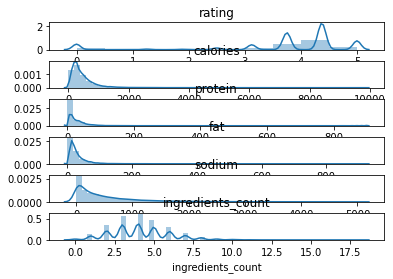

In [4]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
variables = ["rating","calories","protein","fat","sodium", "ingredients_count"]
for i in range(len(variables)): 
    ax = fig.add_subplot(6, 1, i + 1)
    if variables[i] == 'rating':
        sns.distplot(food_data[variables[i]],bins=[0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5], ax=ax)
    else:
        sns.distplot(food_data[variables[i]], ax=ax)
    ax.set_title(variables[i])
plt.show()

For our ingredients variables, the only summary statistics we can make are the top 20 most popular ingredients. There isn't anything too interesting here. As one would expect, common ingredients like Onions, Milk/Cream, and Tomatoes show up in more than 10% of all Epicurious recipes. It is important to note here that we are using recipes from an American website where most users are probably from North America so the ingredients and recipes are biased to that.

Text(0.5, 1.0, 'Most Popular Ingredients')

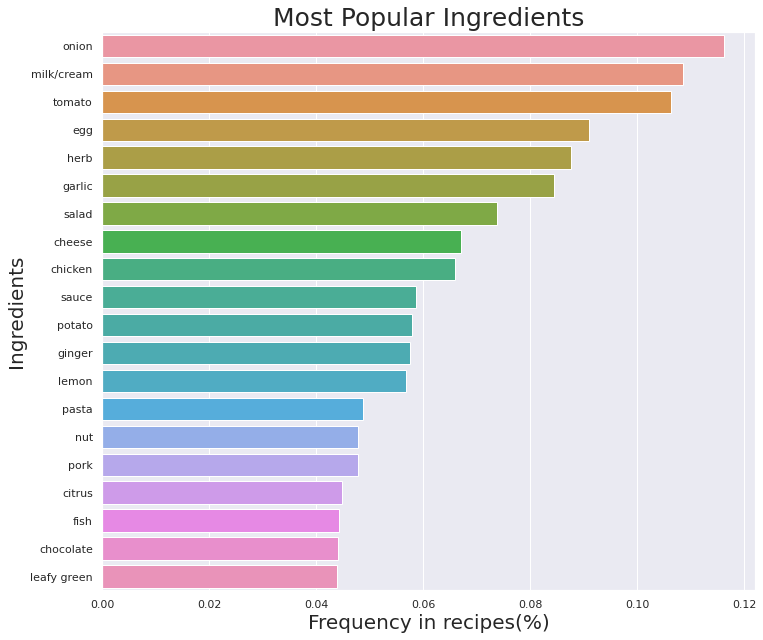

In [5]:
ingredients_count = defaultdict(lambda: 0) # map to count ingrdients

# count each ingredient
for index, row in food_data.iterrows():
    for ingredient in ingredients:
        if row[ingredient] == 1:
            ingredients_count[ingredient] += 1
ingredients_count = dict(ingredients_count)
total_rows = len(food_data.index)

# sort them and change count to percentage
ingredients_count = {k: v/total_rows for k, v in sorted(ingredients_count.items(), key=lambda item: item[1], reverse = True)}# sort by count

# putting it into a list to ensure correct ordering(calling .keys()/.values can cause reordering sometimes)
plot_ingredients = []
plot_count = []
for k,v in ingredients_count.items():
    plot_ingredients.append(k)
    plot_count.append(v)
    
sns.set(rc={'figure.figsize':(11.7,10.27),"axes.labelsize":2})
sns.color_palette("mako")

plot = sns.barplot(x=plot_count[:20], y=plot_ingredients[:20])
plot.set_xlabel("Frequency in recipes(%)",fontsize=20)
plot.set_ylabel("Ingredients",fontsize=20)
plot.set_title("Most Popular Ingredients",fontsize = 25)

### Let's start exploring their relationships!
First, let's explore the relationship between Ratings versus Calories/Protein/Fat/Sodium/Count of Ingredients. We'll make scatterplots using seaborn and they come with automatic regression lines. Also, something important to note is these visuals are not completely accuracte. I've added jitters to the points to spread them so we can see which parts of the scatterplot are more concentrated.

On first glance:
 - **Calories,Protein, and Fat** seem to have a positive correlation with Ratings and very large spreads
     
 - **Sodium and Ingredients Count** seem to have a positive correlation with Ratings and a small spread
 - It's hard to compare how strong each correlation is simply from the slop of the lines as they all operate on different scales with different units
 - It looks like these relationships are linear and we will not need to use polynomials for regression.

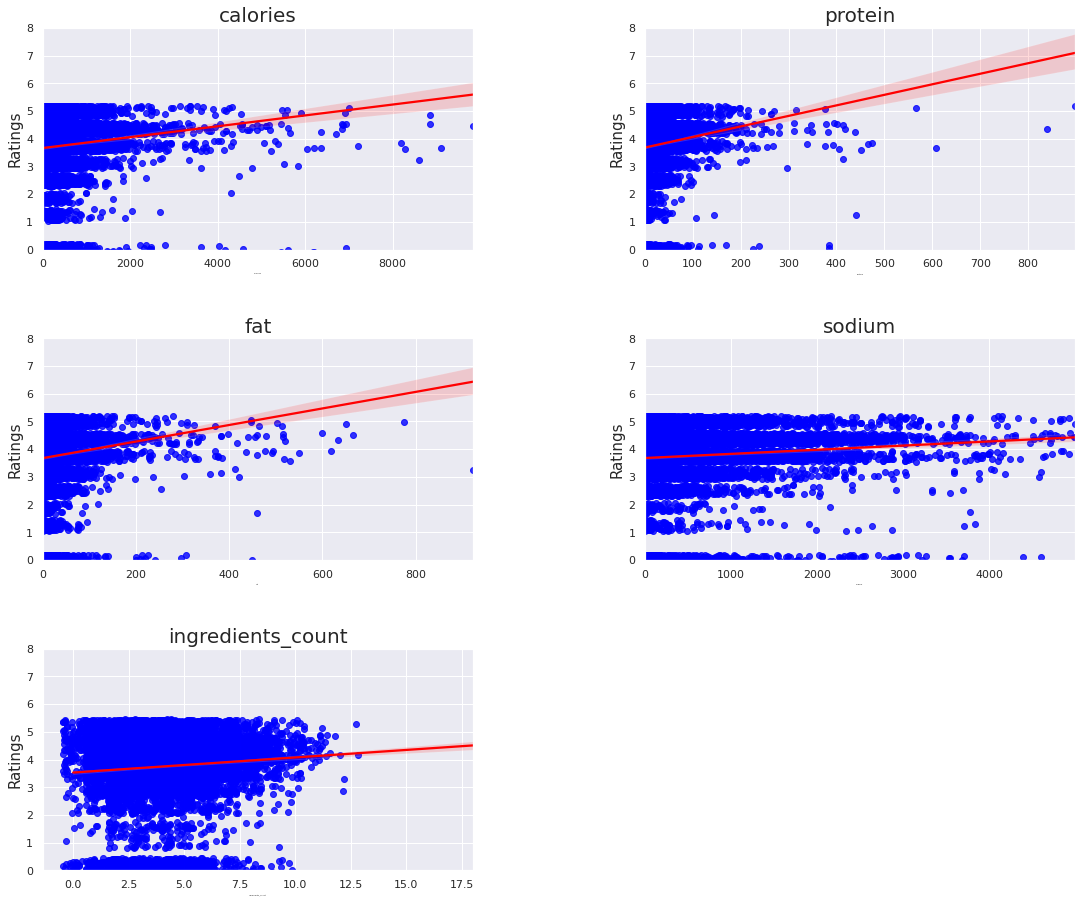

In [6]:
# We add the jitter to make the distribution of data points clearer, it does not influence the regression at all
fig = plt.figure()
fig.set_size_inches(18.5, 15.5)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
predictors = ["calories","protein","fat","sodium","ingredients_count"]
for i in range(len(predictors)): 
    ax = fig.add_subplot(3, 2, i + 1)
    ax.set(ylim=(0, 8))
    if predictors[i] == "ingredients_count":
        sns.regplot(x="ingredients_count", y="rating", data=food_data, x_jitter = .45, y_jitter = .45, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, ax=ax)
    else:           
        sns.regplot(x=predictors[i], y="rating", data=food_data, y_jitter=.2, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, ax=ax)
    ax.set_title(predictors[i], fontsize = 20)
    ax.set_ylabel('Ratings', fontsize = 15)

plt.show()

### Multiple Linear Regression Time!

So let's start with a simple regression. 

Question: Can we predict ratings using just nutrition information(calories, protein, fat, sodium)?
1. First, we need to split the data into a training set and a testing set. We'll use the training set to build the model and the testing set to evaluate it's predictive performance. We are using 80% of our data for the training and 20% for the testing.
2. Next, we'll be using the statsmodel package to run a regression. We are using Rating as our dependent variable and Calories, Protein, Fat, Sodium as our predictors.

Observations:
1. From the t-tests of our predictors, it seems all of our variables are significant predictors meaning.
2. From the coefficients, calories and sodium contribute to a higher rating while protein and fat contribute to a lower rating. 
3. The R-squared of the value is about 50%, meaning our model only explains the variance of only half the points which is a sign that our model's predictive power is not very good.

Answer: No, nutrition information alone is not enough to predict Rating but let's try again with more variables.

In [7]:
ingredients = list(food_data.columns[6:])
X = food_data[['calories','protein','fat','sodium','ingredients_count'] + ingredients]
Y = food_data['rating']
# split data 
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=.2)
    
X_temp = X_train[['calories','protein','fat','sodium']] 
Y_temp = Y_train

# Fit the Linear Regression on Train split
model = sm.OLS(Y_temp, X_temp).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 rating   R-squared (uncentered):                   0.473
Model:                            OLS   Adj. R-squared (uncentered):              0.473
Method:                 Least Squares   F-statistic:                              2816.
Date:                Mon, 21 Dec 2020   Prob (F-statistic):                        0.00
Time:                        07:41:37   Log-Likelihood:                         -31059.
No. Observations:               12535   AIC:                                  6.213e+04
Df Residuals:                   12531   BIC:                                  6.216e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
calories       0.0042      0.000     33.654      0.000       0.004       0.004
protein       -0.0081      0.001     -7.195      0.000      -0.010      -0.006
fat           -0.0249      0.002    -15.509      0.000      -0.028      -0.022
sodium         0.0015   4.37e-05     34.649      0.000       0.001       0.002
==============================================================================
Omnibus:                     8519.911   Durbin-Watson:                   1.193
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           205728.809
Skew:                          -2.932   Prob(JB):                         0.00
Kurtosis:                      21.961   Cond. No.                         63.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So our model isn't the best but let's try using it to predict anyways. We'll be using two metrics: MAE and RMSE.

Mean Absolute Error is the average amount our prediction differs from the actual result.(We'll use this mainly as it is easier to interpret)
Root Mean Square Error is the average of the squared error. RMSE compared to MAE penalizes large errors far more.

From our MAE result, our model on average predicts ratings with an error rate of 2.43(and our Rating's only go from 0 to 5 so it's around half of our entire range!). Our model is predicting things very inaccurately.

In [8]:
X_temp = X_test[['calories','protein','fat','sodium']] 
predicted = model.predict(X_temp)
actual = Y_test

mae = metrics.mean_absolute_error(actual, predicted)
rmse = np.sqrt(metrics.mean_squared_error(actual, predicted)) 
print("MAE:",mae,"RMSE:",rmse)

MAE: 2.4808449351275375 RMSE: 2.885713851888471


New Question: Can we predict ratings using nutrition information and the count of ingredients?

Observations:
1. From the t-tests of our predictors, it seems the number of ingredients is also significant. 
2. The R-squared of the value is about 80%. This is a big improvement in our model

Answer: No, nutrition information alone is not enough to predict Rating but let's try again with more variables.

In [9]:
X_temp = X_train[['calories','protein','fat','sodium','ingredients_count']] 
Y_temp = Y_train

# Fit the Linear Regression on Train split
model = sm.OLS(Y_temp, X_temp).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 rating   R-squared (uncentered):                   0.779
Model:                            OLS   Adj. R-squared (uncentered):              0.779
Method:                 Least Squares   F-statistic:                              8857.
Date:                Mon, 21 Dec 2020   Prob (F-statistic):                        0.00
Time:                        07:41:37   Log-Likelihood:                         -25604.
No. Observations:               12535   AIC:                                  5.122e+04
Df Residuals:                   12530   BIC:                                  5.125e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
calories              0.0011   8.38e-05     12.695      0.000       0.001       0.001
protein              -0.0041      0.001     -5.658      0.000      -0.006      -0.003
fat                  -0.0043      0.001     -4.106      0.000      -0.006      -0.002
sodium                0.0003   2.97e-05     11.342      0.000       0.000       0.000
ingredients_count     0.6623      0.005    131.873      0.000       0.652       0.672
==============================================================================
Omnibus:                     1230.192   Durbin-Watson:                   1.811
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1797.123
Skew:                          -0.760   Prob(JB):                         0.00
Kurtosis:                       4.062   Cond. No.                         307.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
X_temp = X_test[['calories','protein','fat','sodium','ingredients_count']] 
predicted = model.predict(X_temp)
actual = Y_test

mae = metrics.mean_absolute_error(actual, predicted)
rmse = np.sqrt(metrics.mean_squared_error(actual, predicted)) 
print("MAE:",mae,"RMSE:",rmse)

MAE: 1.5297346007665131 RMSE: 1.891169248783165


Let's try improving the model!

New Question: Can we predict ratings using nutrition information and ingredients?
1. We are using Rating as our dependent variable and Calories, Protein, Fat, Sodium, and almost 700 ingredients as our predictors.
2. Odds are, a lot of those ingredients will not be significant predictors. After removing or inserting variables in a model, it needs to be refitted. There are many methods for variable selection but I will be using a Backward Elimination algorithm to remove all variables below 5%. 

Note: Fitting a Multiple Linear Regression many times is time-consuming, it took about 10 minutes to finish.

Observations:
1. From the t-tests of our predictors, only about 
2. From the coefficients, calories and sodium contribute to a higher rating while protein and fat contribute to a lower rating. These findings are not final, we are only interpreting the model.
3. The R-squared of the value is about 50%, meaning our model only explains the variance of only half the points which means our model has very poor predictive power.

Answer: 

In [11]:
X_temp = X_test.copy(deep = True)
Y_temp = Y_test.copy(deep = True)

def remove_most_insignificant(df, results):
    # use operator to find the key which belongs to the maximum value in the dictionary:
    max_p_value = max(results.pvalues.iteritems(), key=operator.itemgetter(1))[0]
    # this is the feature you want to drop:
    df.drop(columns = max_p_value, inplace = True)
    return df

insignificant_feature = True

with np.errstate(divide='ignore',invalid='ignore'):
    while insignificant_feature:
            model = sm.OLS(Y_temp, X_temp)
            results = model.fit()
            significant = [p_value < 0.05 for p_value in results.pvalues]
            if all(significant):
                insignificant_feature = False
            else:
                if X_temp.shape[1] == 1:  # if there's only one insignificant variable left
                    print('No significant features found')
                    results = None
                    insignificant_feature = False
                else:            
                    X_temp = remove_most_insignificant(X_temp, results)
    print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 rating   R-squared (uncentered):                   0.799
Model:                            OLS   Adj. R-squared (uncentered):              0.795
Method:                 Least Squares   F-statistic:                              222.6
Date:                Mon, 21 Dec 2020   Prob (F-statistic):                        0.00
Time:                        07:43:56   Log-Likelihood:                         -6256.0
No. Observations:                3134   AIC:                                  1.262e+04
Df Residuals:                    3079   BIC:                                  1.295e+04
Df Model:                          55                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [12]:
filtered_predictors = list(results.params.index)
X_temp = X_test[filtered_predictors] 
predicted = results.predict(X_temp)
actual = Y_test

mae = metrics.mean_absolute_error(actual, predicted)
rmse = np.sqrt(metrics.mean_squared_error(actual, predicted)) 
print("MAE:",mae,"RMSE:",rmse)

MAE: 1.4255111489998045 RMSE: 1.7811264061735113


             predictor  coefficient
0             calories     0.001259
1              protein    -0.005683
2                  fat    -0.006652
3               sodium     0.000313
4    ingredients_count     0.613082
5                apple     0.524492
6                 bass    -1.524460
7                 beef     0.431075
8                 beet     0.694312
9              biscuit     3.903384
10            bok choy     1.692882
11              carrot    -0.620676
12              cheese     0.313525
13             chicken     0.348597
14           chocolate     0.627558
15              citrus     0.397373
16             cookies     0.572183
17           coriander    -0.846198
18           cranberry     0.797385
19               cumin     1.440715
20  dominican republic    -1.911976
21                 egg     0.229504
22                fish     0.422072
23                 gin    -1.305558
24         ground beef    -1.139904
25              kahlúa     1.345798
26             lettuce    -0

Text(0.5, 1.0, 'Most Popular Ingredients')

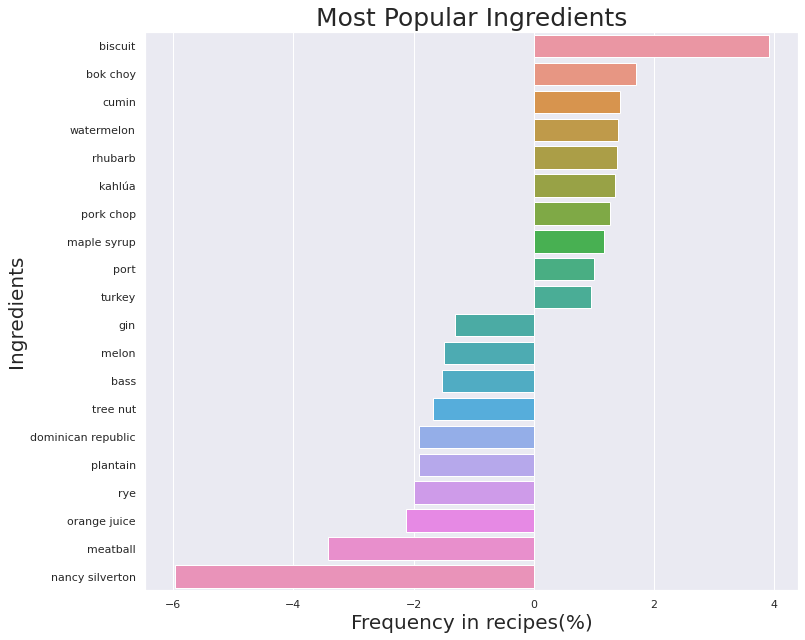

In [13]:
d = {'predictor': results.params.index, 'coefficient': results.params.values}
df = pd.DataFrame(data=d)
print(df)

df.sort_values(by = 'coefficient', ascending = False, inplace = True)
sns.set(rc={'figure.figsize':(11.7,10.27),"axes.labelsize":2})
sns.color_palette("mako")

top_10_bottom_10_predictors = list(df['coefficient'][:10]) + list(df['coefficient'][-10:])
top_10_bottom_10_coefficient = list(df['predictor'][:10]) + list(df['predictor'][-10:])

plot = sns.barplot(x=top_10_bottom_10_predictors, y=top_10_bottom_10_coefficient)
plot.set_xlabel("Frequency in recipes(%)",fontsize=20)
plot.set_ylabel("Ingredients",fontsize=20)
plot.set_title("Most Popular Ingredients",fontsize = 25)

### Is our model done yet? We never accounted for interactions!

##### What is an interaction? 

When the value of one of our predictors depends on another variable, we say there's an interaction. In our case, it is absolutely true as nutrition depends almost entirely on the listed ingredients(some ingredients may not be listed). To deal with this, we normally create an interaction variable which represents the combined effect of two predictors on some response. However, it's not feasible for our data. With 4 nutrition variables and around 700 ingredients, every ingredient would need an interaction variable for every nutrition variable, so we'd end up with 2800 variables for our regression!

##### So what can we do?
Let's try fitting the data without 


## Conclusion and Reflection
I said at the start that cooking recipe ratings were subjective. From our analysis, I think you could agree that predicting recipe ratings with high accuracy is hard. Compared to something very numerically driven, when working with a very human topic like food, a data-drive solution may not be the best approach. However, I'm sure we've gained some interesting insights.
This project's greatest challenge was cleaning the data and handling the large number of predictors. To be honest
If I had more time to do this project, there are a list of things I'd like to do:
1. Making my own scraper would have been ideal to get data in the exact state I wanted
2. Finding a more efficient yet effective variable selection method. Forward Selection or Stepwise Regression would be interesting to test out.
3. Finding a way to deal with the interactions between ingredients and nutrition other than just making a separate model entirely
4. The original data contained more variables like labels for occasions or dietary restrictions that were statistically really interesting but it would overcomplicate the theme of this project.